# Assessment 1: Predict diabetes using Perceptron

## Overview

The first assignment is to implement, describe, and test
a specific algorithm called Perceptron (which can be
interpreted as a dense layer neural network) for predicting
diabetes (using the diabetes dataset provided). 

## Import Packages


In [73]:
# Common imports
import numpy as np
import pandas as pd

# visualizaiton
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning & Deep learning imports
import sklearn
import torch


## Data Loading

In [74]:
def load_dataset(filename):
    # Read the data using whitespace as delimiter, assuming no headers
    data = pd.read_csv(filename, sep='\s+', header=None)
    
    # Extract labels and initialize the matrix for features
    labels = data.iloc[:, 0].apply(lambda x: 1 if int(x) == 1 else 0).values
    num_samples = data.shape[0]

    # Prepare to find the maximum index for feature array initialization
    max_index = 0
    for index, row in data.iterrows():
        for item in row[1:]:
            if isinstance(item, str) and ':' in item:
                feature_idx = int(item.split(':')[0])
                if feature_idx > max_index:
                    max_index = feature_idx
                    
    # Initialize the features array with NaN values
    features = np.full((num_samples, max_index), np.nan, dtype=np.float32)

    # Populate the features array
    for i, row in enumerate(data.itertuples(index=False)):
        for item in row[1:]:  # Skip the first element as it's the label
            if isinstance(item, str) and ':' in item:
                idx, val = item.split(':')
                features[i, int(idx) - 1] = float(val)  # Correct index and convert value

    # Convert labels and features into PyTorch tensors
    return torch.tensor(features), torch.tensor(labels, dtype=torch.float32)

# Load the pre-processed data diabetes_scale.txt
features, labels = load_dataset('diabetes_scale.txt')
print(features.shape, labels.shape)

torch.Size([768, 8]) torch.Size([768])


## Check NaN values and the distribution of each feature

In [80]:
features_np = features.numpy()
labels_np = labels.numpy()

# Check for rows with missing values (np.nan)
rows_with_nan = np.any(np.isnan(features_np), axis=1)  # Returns a boolean array: True if the row has any NaN values

# Get the indices of rows with NaN values
nan_indices = np.where(rows_with_nan)[0]
print(f"Rows with NaN values: {nan_indices}")

Rows with NaN values: [ 14  24 236 259 285 401 458 517 658]


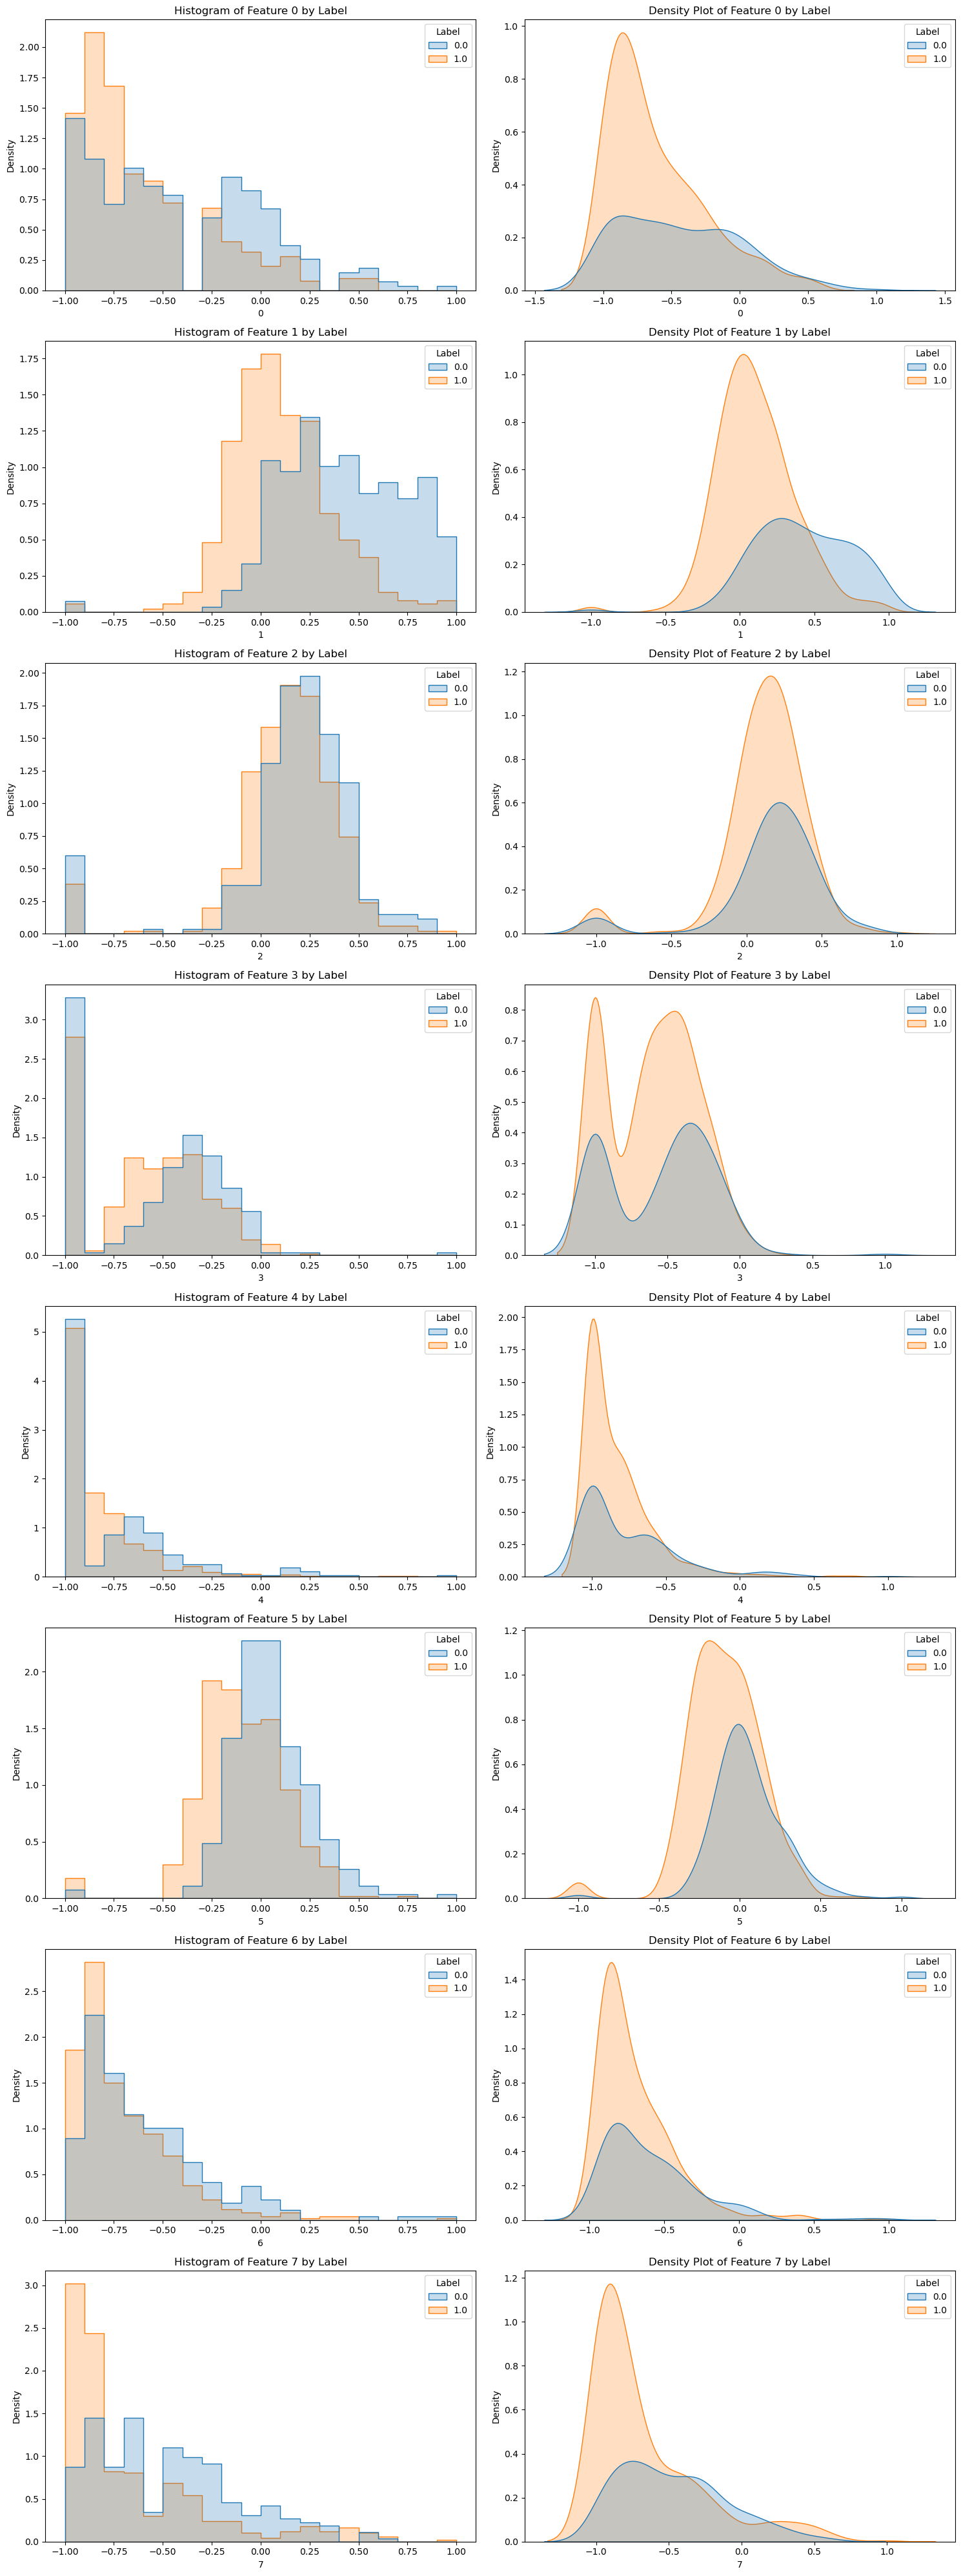

In [81]:
# Create a DataFrame for easier manipulation
df = pd.DataFrame(features_np)
df['Label'] = labels_np  # Add labels as a column in the DataFrame

# Set the number of features you want to plot (for simplicity, plotting 3 features here)
num_features = 8

plt.figure(figsize=(15, 5 * num_features))
for i in range(num_features):
    plt.subplot(num_features, 2, 2 * i + 1)
    sns.histplot(data=df, x=i, hue='Label', element='step', stat='density', common_norm=False, bins=20)
    plt.title(f'Histogram of Feature {i} by Label')

    plt.subplot(num_features, 2, 2 * i + 2)
    sns.kdeplot(data=df, x=i, hue='Label', fill=True)
    plt.title(f'Density Plot of Feature {i} by Label')

plt.tight_layout()
plt.show()

## Perceptron Model

In [82]:
import torch.nn as nn
import torch.optim as optim

class PyTorchPerceptron(nn.Module):
    def __init__(self, input_dim):
        super(PyTorchPerceptron, self).__init__()
        self.fc = nn.Linear(input_dim, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.fc(x))

In [83]:
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader, TensorDataset

class PyTorchPerceptronClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, epochs=20, batch_size=16, learning_rate=0.001):
        self.input_dim = input_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.model = PyTorchPerceptron(input_dim)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
    
    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        self.model.train()
        for epoch in range(self.epochs):
            for inputs, targets in loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                self.optimizer.step()
        return self
    
    def predict(self, X):
        self.model.eval()
        X_tensor = torch.tensor(X, dtype=torch.float32)
        with torch.no_grad():
            outputs = self.model(X_tensor)
        return (outputs.numpy() > 0.5).astype(int)
    
    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

## Pipeline of imuptation and training

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np

# Load and split your data
# X and y should be loaded as numpy arrays from your dataset
X_train, X_test, y_train, y_test = train_test_split(features_np, labels_np, test_size=0.2, random_state=42, stratify=labels_np)

# Create an imputer object and a PyTorch model wrapped for scikit-learn
imputer = SimpleImputer(strategy='median')
pytorch_model = PyTorchPerceptronClassifier(input_dim=X_train.shape[1])

# Create the pipeline
pipeline = Pipeline([
    ('imputer', imputer),
    ('classifier', pytorch_model)
])

# Fit the model
pipeline.fit(X_train, y_train)

# Evaluate the model
accuracy = pipeline.score(X_test, y_test)
print(f"Accuracy of the PyTorch model within the scikit-learn pipeline: {accuracy:.4f}")

Accuracy of the PyTorch model within the scikit-learn pipeline: 0.6435
